In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
import math

In [3]:
# %load ./model/basic_layers.py
import torch
import torch.nn as nn
from torch.nn import init
import functools
from torch.autograd import Variable
import numpy as np

class ResidualBlock(nn.Module):
    def __init__(self, input_channels, output_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.stride = stride
        self.bn1 = nn.BatchNorm2d(input_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(input_channels, output_channels//4, 1, 1, bias = False)
        self.bn2 = nn.BatchNorm2d(output_channels//4)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(output_channels//4, output_channels//4, 3, stride, padding = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(output_channels//4)
        self.relu = nn.ReLU(inplace=True)
        self.conv3 = nn.Conv2d(output_channels//4, output_channels, 1, 1, bias = False)
        self.conv4 = nn.Conv2d(input_channels, output_channels , 1, stride, bias = False)
        
    def forward(self, x):
        residual = x
        out = self.bn1(x)
        out1 = self.relu(out)
        out = self.conv1(out1)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn3(out)
        out = self.relu(out)
        out = self.conv3(out)
        if (self.input_channels != self.output_channels) or (self.stride !=1 ):
            residual = self.conv4(out1)
        out += residual
        return out

In [4]:
# %load ./model/attention_module.py
import torch
import torch.nn as nn
from torch.nn import init
import functools
from torch.autograd import Variable
import numpy as np

# from .basic_layers import ResidualBlock


class AttentionModule_pre(nn.Module):

    def __init__(self, in_channels, out_channels, size1, size2, size3):
        super(AttentionModule_pre, self).__init__()
        self.first_residual_blocks = ResidualBlock(in_channels, out_channels)

        self.trunk_branches = nn.Sequential(
            ResidualBlock(in_channels, out_channels),
            ResidualBlock(in_channels, out_channels)
         )

        self.mpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.softmax1_blocks = ResidualBlock(in_channels, out_channels)

        self.skip1_connection_residual_block = ResidualBlock(in_channels, out_channels)

        self.mpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.softmax2_blocks = ResidualBlock(in_channels, out_channels)

        self.skip2_connection_residual_block = ResidualBlock(in_channels, out_channels)

        self.mpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.softmax3_blocks = nn.Sequential(
            ResidualBlock(in_channels, out_channels),
            ResidualBlock(in_channels, out_channels)
        )

        self.interpolation3 = nn.UpsamplingBilinear2d(size=size3)

        self.softmax4_blocks = ResidualBlock(in_channels, out_channels)

        self.interpolation2 = nn.UpsamplingBilinear2d(size=size2)

        self.softmax5_blocks = ResidualBlock(in_channels, out_channels)

        self.interpolation1 = nn.UpsamplingBilinear2d(size=size1)

        self.softmax6_blocks = nn.Sequential(
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels , kernel_size = 1, stride = 1, bias = False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels , kernel_size = 1, stride = 1, bias = False),
            nn.Sigmoid()
        )

        self.last_blocks = ResidualBlock(in_channels, out_channels)

    def forward(self, x):
        x = self.first_residual_blocks(x)
        out_trunk = self.trunk_branches(x)
        out_mpool1 = self.mpool1(x)
        out_softmax1 = self.softmax1_blocks(out_mpool1)
        out_skip1_connection = self.skip1_connection_residual_block(out_softmax1)
        out_mpool2 = self.mpool2(out_softmax1)
        out_softmax2 = self.softmax2_blocks(out_mpool2)
        out_skip2_connection = self.skip2_connection_residual_block(out_softmax2)
        out_mpool3 = self.mpool3(out_softmax2)
        out_softmax3 = self.softmax3_blocks(out_mpool3)
        #
        out_interp3 = self.interpolation3(out_softmax3)
        # print(out_skip2_connection.data)
        # print(out_interp3.data)
        out = out_interp3 + out_skip2_connection
        out_softmax4 = self.softmax4_blocks(out)
        out_interp2 = self.interpolation2(out_softmax4)
        out = out_interp2 + out_skip1_connection
        out_softmax5 = self.softmax5_blocks(out)
        out_interp1 = self.interpolation1(out_softmax5)
        out_softmax6 = self.softmax6_blocks(out_interp1)
        out = (1 + out_softmax6) * out_trunk
        out_last = self.last_blocks(out)

        return out_last


class AttentionModule_stage0(nn.Module):
    # input size is 112*112
    def __init__(self, in_channels, out_channels, size1=(112, 112), size2=(56, 56), size3=(28, 28), size4=(14, 14)):
        super(AttentionModule_stage0, self).__init__()
        self.first_residual_blocks = ResidualBlock(in_channels, out_channels)

        self.trunk_branches = nn.Sequential(
            ResidualBlock(in_channels, out_channels),
            ResidualBlock(in_channels, out_channels)
         )

        self.mpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # 56*56
        self.softmax1_blocks = ResidualBlock(in_channels, out_channels)

        self.skip1_connection_residual_block = ResidualBlock(in_channels, out_channels)

        self.mpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # 28*28
        self.softmax2_blocks = ResidualBlock(in_channels, out_channels)

        self.skip2_connection_residual_block = ResidualBlock(in_channels, out_channels)

        self.mpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # 14*14
        self.softmax3_blocks = ResidualBlock(in_channels, out_channels)
        self.skip3_connection_residual_block = ResidualBlock(in_channels, out_channels)
        self.mpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # 7*7
        self.softmax4_blocks = nn.Sequential(
            ResidualBlock(in_channels, out_channels),
            ResidualBlock(in_channels, out_channels)
        )
        self.interpolation4 = nn.UpsamplingBilinear2d(size=size4)
        self.softmax5_blocks = ResidualBlock(in_channels, out_channels)
        self.interpolation3 = nn.UpsamplingBilinear2d(size=size3)
        self.softmax6_blocks = ResidualBlock(in_channels, out_channels)
        self.interpolation2 = nn.UpsamplingBilinear2d(size=size2)
        self.softmax7_blocks = ResidualBlock(in_channels, out_channels)
        self.interpolation1 = nn.UpsamplingBilinear2d(size=size1)

        self.softmax8_blocks = nn.Sequential(
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=1, stride=1, bias = False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels , kernel_size=1, stride=1, bias = False),
            nn.Sigmoid()
        )

        self.last_blocks = ResidualBlock(in_channels, out_channels)

    def forward(self, x):
        # 112*112
        x = self.first_residual_blocks(x)
        out_trunk = self.trunk_branches(x)
        out_mpool1 = self.mpool1(x)
        # 56*56
        out_softmax1 = self.softmax1_blocks(out_mpool1)
        out_skip1_connection = self.skip1_connection_residual_block(out_softmax1)
        out_mpool2 = self.mpool2(out_softmax1)
        # 28*28
        out_softmax2 = self.softmax2_blocks(out_mpool2)
        out_skip2_connection = self.skip2_connection_residual_block(out_softmax2)
        out_mpool3 = self.mpool3(out_softmax2)
        # 14*14
        out_softmax3 = self.softmax3_blocks(out_mpool3)
        out_skip3_connection = self.skip3_connection_residual_block(out_softmax3)
        out_mpool4 = self.mpool4(out_softmax3)
        # 7*7
        out_softmax4 = self.softmax4_blocks(out_mpool4)
        out_interp4 = self.interpolation4(out_softmax4) + out_softmax3
        out = out_interp4 + out_skip3_connection
        out_softmax5 = self.softmax5_blocks(out)
        out_interp3 = self.interpolation3(out_softmax5) + out_softmax2
        # print(out_skip2_connection.data)
        # print(out_interp3.data)
        out = out_interp3 + out_skip2_connection
        out_softmax6 = self.softmax6_blocks(out)
        out_interp2 = self.interpolation2(out_softmax6) + out_softmax1
        out = out_interp2 + out_skip1_connection
        out_softmax7 = self.softmax7_blocks(out)
        out_interp1 = self.interpolation1(out_softmax7) + out_trunk
        out_softmax8 = self.softmax8_blocks(out_interp1)
        out = (1 + out_softmax8) * out_trunk
        out_last = self.last_blocks(out)

        return out_last


class AttentionModule_stage1(nn.Module):
    # input size is 56*56
    def __init__(self, in_channels, out_channels, size1=(56, 56), size2=(28, 28), size3=(14, 14)):
        super(AttentionModule_stage1, self).__init__()
        self.first_residual_blocks = ResidualBlock(in_channels, out_channels)

        self.trunk_branches = nn.Sequential(
            ResidualBlock(in_channels, out_channels),
            ResidualBlock(in_channels, out_channels)
         )

        self.mpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.softmax1_blocks = ResidualBlock(in_channels, out_channels)

        self.skip1_connection_residual_block = ResidualBlock(in_channels, out_channels)

        self.mpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.softmax2_blocks = ResidualBlock(in_channels, out_channels)

        self.skip2_connection_residual_block = ResidualBlock(in_channels, out_channels)

        self.mpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.softmax3_blocks = nn.Sequential(
            ResidualBlock(in_channels, out_channels),
            ResidualBlock(in_channels, out_channels)
        )

        self.interpolation3 = nn.UpsamplingBilinear2d(size=size3)

        self.softmax4_blocks = ResidualBlock(in_channels, out_channels)

        self.interpolation2 = nn.UpsamplingBilinear2d(size=size2)

        self.softmax5_blocks = ResidualBlock(in_channels, out_channels)

        self.interpolation1 = nn.UpsamplingBilinear2d(size=size1)

        self.softmax6_blocks = nn.Sequential(
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels , kernel_size = 1, stride = 1, bias = False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels , kernel_size = 1, stride = 1, bias = False),
            nn.Sigmoid()
        )

        self.last_blocks = ResidualBlock(in_channels, out_channels)

    def forward(self, x):
        x = self.first_residual_blocks(x)
        out_trunk = self.trunk_branches(x)
        out_mpool1 = self.mpool1(x)
        out_softmax1 = self.softmax1_blocks(out_mpool1)
        out_skip1_connection = self.skip1_connection_residual_block(out_softmax1)
        out_mpool2 = self.mpool2(out_softmax1)
        out_softmax2 = self.softmax2_blocks(out_mpool2)
        out_skip2_connection = self.skip2_connection_residual_block(out_softmax2)
        out_mpool3 = self.mpool3(out_softmax2)
        out_softmax3 = self.softmax3_blocks(out_mpool3)
        #
        out_interp3 = self.interpolation3(out_softmax3) + out_softmax2
        # print(out_skip2_connection.data)
        # print(out_interp3.data)
        out = out_interp3 + out_skip2_connection
        out_softmax4 = self.softmax4_blocks(out)
        out_interp2 = self.interpolation2(out_softmax4) + out_softmax1
        out = out_interp2 + out_skip1_connection
        out_softmax5 = self.softmax5_blocks(out)
        out_interp1 = self.interpolation1(out_softmax5) + out_trunk
        out_softmax6 = self.softmax6_blocks(out_interp1)
        out = (1 + out_softmax6) * out_trunk
        out_last = self.last_blocks(out)

        return out_last


class AttentionModule_stage2(nn.Module):
    # input image size is 28*28
    def __init__(self, in_channels, out_channels, size1=(28, 28), size2=(14, 14)):
        super(AttentionModule_stage2, self).__init__()
        self.first_residual_blocks = ResidualBlock(in_channels, out_channels)

        self.trunk_branches = nn.Sequential(
            ResidualBlock(in_channels, out_channels),
            ResidualBlock(in_channels, out_channels)
         )

        self.mpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.softmax1_blocks = ResidualBlock(in_channels, out_channels)

        self.skip1_connection_residual_block = ResidualBlock(in_channels, out_channels)

        self.mpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.softmax2_blocks = nn.Sequential(
            ResidualBlock(in_channels, out_channels),
            ResidualBlock(in_channels, out_channels)
        )

        self.interpolation2 = nn.UpsamplingBilinear2d(size=size2)

        self.softmax3_blocks = ResidualBlock(in_channels, out_channels)

        self.interpolation1 = nn.UpsamplingBilinear2d(size=size1)

        self.softmax4_blocks = nn.Sequential(
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.Sigmoid()
        )

        self.last_blocks = ResidualBlock(in_channels, out_channels)

    def forward(self, x):
        x = self.first_residual_blocks(x)
        out_trunk = self.trunk_branches(x)
        out_mpool1 = self.mpool1(x)
        out_softmax1 = self.softmax1_blocks(out_mpool1)
        out_skip1_connection = self.skip1_connection_residual_block(out_softmax1)
        out_mpool2 = self.mpool2(out_softmax1)
        out_softmax2 = self.softmax2_blocks(out_mpool2)

        out_interp2 = self.interpolation2(out_softmax2) + out_softmax1
        # print(out_skip2_connection.data)
        # print(out_interp3.data)
        out = out_interp2 + out_skip1_connection
        out_softmax3 = self.softmax3_blocks(out)
        out_interp1 = self.interpolation1(out_softmax3) + out_trunk
        out_softmax4 = self.softmax4_blocks(out_interp1)
        out = (1 + out_softmax4) * out_trunk
        out_last = self.last_blocks(out)

        return out_last


class AttentionModule_stage3(nn.Module):
    # input image size is 14*14
    def __init__(self, in_channels, out_channels, size1=(14, 14)):
        super(AttentionModule_stage3, self).__init__()
        self.first_residual_blocks = ResidualBlock(in_channels, out_channels)

        self.trunk_branches = nn.Sequential(
            ResidualBlock(in_channels, out_channels),
            ResidualBlock(in_channels, out_channels)
         )

        self.mpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.softmax1_blocks = nn.Sequential(
            ResidualBlock(in_channels, out_channels),
            ResidualBlock(in_channels, out_channels)
        )

        self.interpolation1 = nn.UpsamplingBilinear2d(size=size1)

        self.softmax2_blocks = nn.Sequential(
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.Sigmoid()
        )

        self.last_blocks = ResidualBlock(in_channels, out_channels)

    def forward(self, x):
        x = self.first_residual_blocks(x)
        out_trunk = self.trunk_branches(x)
        out_mpool1 = self.mpool1(x)
        out_softmax1 = self.softmax1_blocks(out_mpool1)

        out_interp1 = self.interpolation1(out_softmax1) + out_trunk
        out_softmax2 = self.softmax2_blocks(out_interp1)
        out = (1 + out_softmax2) * out_trunk
        out_last = self.last_blocks(out)

        return out_last


class AttentionModule_stage1_cifar(nn.Module):
    # input size is 16*16
    def __init__(self, in_channels, out_channels, size1=(16, 16), size2=(8, 8)):
        super(AttentionModule_stage1_cifar, self).__init__()
        self.first_residual_blocks = ResidualBlock(in_channels, out_channels)

        self.trunk_branches = nn.Sequential(
            ResidualBlock(in_channels, out_channels),
            ResidualBlock(in_channels, out_channels)
         )

        self.mpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  # 8*8

        self.down_residual_blocks1 = ResidualBlock(in_channels, out_channels)

        self.skip1_connection_residual_block = ResidualBlock(in_channels, out_channels)

        self.mpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  # 4*4

        self.middle_2r_blocks = nn.Sequential(
            ResidualBlock(in_channels, out_channels),
            ResidualBlock(in_channels, out_channels)
        )

        self.interpolation1 = nn.UpsamplingBilinear2d(size=size2)  # 8*8

        self.up_residual_blocks1 = ResidualBlock(in_channels, out_channels)

        self.interpolation2 = nn.UpsamplingBilinear2d(size=size1)  # 16*16

        self.conv1_1_blocks = nn.Sequential(
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=1, stride=1, bias = False),
            nn.Sigmoid()
        )

        self.last_blocks = ResidualBlock(in_channels, out_channels)

    def forward(self, x):
        x = self.first_residual_blocks(x)
        out_trunk = self.trunk_branches(x)
        out_mpool1 = self.mpool1(x)
        out_down_residual_blocks1 = self.down_residual_blocks1(out_mpool1)
        out_skip1_connection = self.skip1_connection_residual_block(out_down_residual_blocks1)
        out_mpool2 = self.mpool2(out_down_residual_blocks1)
        out_middle_2r_blocks = self.middle_2r_blocks(out_mpool2)
        #
        out_interp = self.interpolation1(out_middle_2r_blocks) + out_down_residual_blocks1
        # print(out_skip2_connection.data)
        # print(out_interp3.data)
        out = out_interp + out_skip1_connection
        out_up_residual_blocks1 = self.up_residual_blocks1(out)
        out_interp2 = self.interpolation2(out_up_residual_blocks1) + out_trunk
        out_conv1_1_blocks = self.conv1_1_blocks(out_interp2)
        out = (1 + out_conv1_1_blocks) * out_trunk
        out_last = self.last_blocks(out)

        return out_last


class AttentionModule_stage2_cifar(nn.Module):
    # input size is 8*8
    def __init__(self, in_channels, out_channels, size=(8, 8)):
        super(AttentionModule_stage2_cifar, self).__init__()
        self.first_residual_blocks = ResidualBlock(in_channels, out_channels)

        self.trunk_branches = nn.Sequential(
            ResidualBlock(in_channels, out_channels),
            ResidualBlock(in_channels, out_channels)
         )

        self.mpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  # 4*4

        self.middle_2r_blocks = nn.Sequential(
            ResidualBlock(in_channels, out_channels),
            ResidualBlock(in_channels, out_channels)
        )

        self.interpolation1 = nn.UpsamplingBilinear2d(size=size)  # 8*8

        self.conv1_1_blocks = nn.Sequential(
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=1, stride=1, bias = False),
            nn.Sigmoid()
        )

        self.last_blocks = ResidualBlock(in_channels, out_channels)

    def forward(self, x):
        x = self.first_residual_blocks(x)
        out_trunk = self.trunk_branches(x)
        out_mpool1 = self.mpool1(x)
        out_middle_2r_blocks = self.middle_2r_blocks(out_mpool1)
        #
        out_interp = self.interpolation1(out_middle_2r_blocks) + out_trunk
        # print(out_skip2_connection.data)
        # print(out_interp3.data)
        out_conv1_1_blocks = self.conv1_1_blocks(out_interp)
        out = (1 + out_conv1_1_blocks) * out_trunk
        out_last = self.last_blocks(out)

        return out_last


class AttentionModule_stage3_cifar(nn.Module):
    # input size is 4*4
    def __init__(self, in_channels, out_channels, size=(8, 8)):
        super(AttentionModule_stage3_cifar, self).__init__()
        self.first_residual_blocks = ResidualBlock(in_channels, out_channels)

        self.trunk_branches = nn.Sequential(
            ResidualBlock(in_channels, out_channels),
            ResidualBlock(in_channels, out_channels)
         )

        self.middle_2r_blocks = nn.Sequential(
            ResidualBlock(in_channels, out_channels),
            ResidualBlock(in_channels, out_channels)
        )

        self.conv1_1_blocks = nn.Sequential(
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=1, stride=1, bias = False),
            nn.Sigmoid()
        )

        self.last_blocks = ResidualBlock(in_channels, out_channels)

    def forward(self, x):
        x = self.first_residual_blocks(x)
        out_trunk = self.trunk_branches(x)
        out_middle_2r_blocks = self.middle_2r_blocks(x)
        #
        out_conv1_1_blocks = self.conv1_1_blocks(out_middle_2r_blocks)
        out = (1 + out_conv1_1_blocks) * out_trunk
        out_last = self.last_blocks(out)

        return out_last

In [5]:
# %load ./model/residual_attention_network.py
import torch
import torch.nn as nn
from torch.nn import init
import functools
from torch.autograd import Variable
import numpy as np
# from .basic_layers import ResidualBlock
# from .attention_module import AttentionModule_stage1, AttentionModule_stage2, AttentionModule_stage3, AttentionModule_stage0
# from .attention_module import AttentionModule_stage1_cifar, AttentionModule_stage2_cifar, AttentionModule_stage3_cifar


class ResidualAttentionModel_448input(nn.Module):
    # for input size 448
    def __init__(self):
        super(ResidualAttentionModel_448input, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias = False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.mpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # tbq add
        # 112*112
        self.residual_block0 = ResidualBlock(64, 128)
        self.attention_module0 = AttentionModule_stage0(128, 128)
        # tbq add end
        self.residual_block1 = ResidualBlock(128, 256, 2)
        # 56*56
        self.attention_module1 = AttentionModule_stage1(256, 256)
        self.residual_block2 = ResidualBlock(256, 512, 2)
        self.attention_module2 = AttentionModule_stage2(512, 512)
        self.attention_module2_2 = AttentionModule_stage2(512, 512)  # tbq add
        self.residual_block3 = ResidualBlock(512, 1024, 2)
        self.attention_module3 = AttentionModule_stage3(1024, 1024)
        self.attention_module3_2 = AttentionModule_stage3(1024, 1024)  # tbq add
        self.attention_module3_3 = AttentionModule_stage3(1024, 1024)  # tbq add
        self.residual_block4 = ResidualBlock(1024, 2048, 2)
        self.residual_block5 = ResidualBlock(2048, 2048)
        self.residual_block6 = ResidualBlock(2048, 2048)
        self.mpool2 = nn.Sequential(
            nn.BatchNorm2d(2048),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=7, stride=1)
        )
        self.fc = nn.Linear(2048,7)

    def forward(self, x):
        out = self.conv1(x)
        out = self.mpool1(out)
        out = self.residual_block0(out)
        out = self.attention_module0(out)
        # print(out.data)
        out = self.residual_block1(out)
        out = self.attention_module1(out)
        out = self.residual_block2(out)
        out = self.attention_module2(out)
        out = self.attention_module2_2(out)
        out = self.residual_block3(out)
        # print(out.data)
        out = self.attention_module3(out)
        out = self.attention_module3_2(out)
        out = self.attention_module3_3(out)
        out = self.residual_block4(out)
        out = self.residual_block5(out)
        out = self.residual_block6(out)
        out = self.mpool2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)

        return out


class ResidualAttentionModel_92(nn.Module):
    # for input size 224
    def __init__(self):
        super(ResidualAttentionModel_92, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias = False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.mpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.residual_block1 = ResidualBlock(64, 256)
        self.attention_module1 = AttentionModule_stage1(256, 256)
        self.residual_block2 = ResidualBlock(256, 512, 2)
        self.attention_module2 = AttentionModule_stage2(512, 512)
        self.attention_module2_2 = AttentionModule_stage2(512, 512)  # tbq add
        self.residual_block3 = ResidualBlock(512, 1024, 2)
        self.attention_module3 = AttentionModule_stage3(1024, 1024)
        self.attention_module3_2 = AttentionModule_stage3(1024, 1024)  # tbq add
        self.attention_module3_3 = AttentionModule_stage3(1024, 1024)  # tbq add
        self.residual_block4 = ResidualBlock(1024, 2048, 2)
        self.residual_block5 = ResidualBlock(2048, 2048)
        self.residual_block6 = ResidualBlock(2048, 2048)
        self.mpool2 = nn.Sequential(
            nn.BatchNorm2d(2048),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=7, stride=1)
        )
        self.fc = nn.Linear(2048,7)

    def forward(self, x):
        out = self.conv1(x)
        out = self.mpool1(out)
        # print(out.data)
        out = self.residual_block1(out)
        out = self.attention_module1(out)
        out = self.residual_block2(out)
        out = self.attention_module2(out)
        out = self.attention_module2_2(out)
        out = self.residual_block3(out)
        # print(out.data)
        out = self.attention_module3(out)
        out = self.attention_module3_2(out)
        out = self.attention_module3_3(out)
        out = self.residual_block4(out)
        out = self.residual_block5(out)
        out = self.residual_block6(out)
        out = self.mpool2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)

        return out


class ResidualAttentionModel_56(nn.Module):
    # for input size 224
    def __init__(self):
        super(ResidualAttentionModel_56, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias = False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.mpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.residual_block1 = ResidualBlock(64, 256)
        self.attention_module1 = AttentionModule_stage1(256, 256)
        self.residual_block2 = ResidualBlock(256, 512, 2)
        self.attention_module2 = AttentionModule_stage2(512, 512)
        self.residual_block3 = ResidualBlock(512, 1024, 2)
        self.attention_module3 = AttentionModule_stage3(1024, 1024)
        self.residual_block4 = ResidualBlock(1024, 2048, 2)
        self.residual_block5 = ResidualBlock(2048, 2048)
        self.residual_block6 = ResidualBlock(2048, 2048)
        self.mpool2 = nn.Sequential(
            nn.BatchNorm2d(2048),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=7, stride=1)
        )
        self.fc = nn.Linear(2048,7)

    def forward(self, x):
        out = self.conv1(x)
        out = self.mpool1(out)
        # print(out.data)
        out = self.residual_block1(out)
        out = self.attention_module1(out)
        out = self.residual_block2(out)
        out = self.attention_module2(out)
        out = self.residual_block3(out)
        # print(out.data)
        out = self.attention_module3(out)
        out = self.residual_block4(out)
        out = self.residual_block5(out)
        out = self.residual_block6(out)
        out = self.mpool2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)

        return out


class ResidualAttentionModel_92_32input(nn.Module):
    # for input size 32
    def __init__(self):
        super(ResidualAttentionModel_92_32input, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )  # 32*32
        self.mpool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # 16*16
        self.residual_block1 = ResidualBlock(32, 128)  # 16*16
        self.attention_module1 = AttentionModule_stage1_cifar(128, 128)  # 16*16
        self.residual_block2 = ResidualBlock(128, 256, 2)  # 8*8
        self.attention_module2 = AttentionModule_stage2_cifar(256, 256)  # 8*8
        self.attention_module2_2 = AttentionModule_stage2_cifar(256, 256)  # 8*8 # tbq add
        self.residual_block3 = ResidualBlock(256, 512, 2)  # 4*4
        self.attention_module3 = AttentionModule_stage3_cifar(512, 512)  # 4*4
        self.attention_module3_2 = AttentionModule_stage3_cifar(512, 512)  # 4*4 # tbq add
        self.attention_module3_3 = AttentionModule_stage3_cifar(512, 512)  # 4*4 # tbq add
        self.residual_block4 = ResidualBlock(512, 1024)  # 4*4
        self.residual_block5 = ResidualBlock(1024, 1024)  # 4*4
        self.residual_block6 = ResidualBlock(1024, 1024)  # 4*4
        self.mpool2 = nn.Sequential(
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=4, stride=1)
        )
        self.fc = nn.Linear(1024,7)

    def forward(self, x):
        out = self.conv1(x)
        out = self.mpool1(out)
        # print(out.data)
        out = self.residual_block1(out)
        out = self.attention_module1(out)
        out = self.residual_block2(out)
        out = self.attention_module2(out)
        out = self.attention_module2_2(out)
        out = self.residual_block3(out)
        # print(out.data)
        out = self.attention_module3(out)
        out = self.attention_module3_2(out)
        out = self.attention_module3_3(out)
        out = self.residual_block4(out)
        out = self.residual_block5(out)
        out = self.residual_block6(out)
        out = self.mpool2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)

        return out


class ResidualAttentionModel_92_32input_update(nn.Module):
    # for input size 32
    def __init__(self):
        super(ResidualAttentionModel_92_32input_update, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )  # 32*32
        # self.mpool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # 16*16
        self.residual_block1 = ResidualBlock(32, 128)  # 32*32
        self.attention_module1 = AttentionModule_stage1_cifar(128, 128, size1=(32, 32), size2=(16, 16))  # 32*32
        self.residual_block2 = ResidualBlock(128, 256, 2)  # 16*16
        self.attention_module2 = AttentionModule_stage2_cifar(256, 256, size=(16, 16))  # 16*16
        self.attention_module2_2 = AttentionModule_stage2_cifar(256, 256, size=(16, 16))  # 16*16 # tbq add
        self.residual_block3 = ResidualBlock(256, 512, 2)  # 4*4
        self.attention_module3 = AttentionModule_stage3_cifar(512, 512)  # 8*8
        self.attention_module3_2 = AttentionModule_stage3_cifar(512, 512)  # 8*8 # tbq add
        self.attention_module3_3 = AttentionModule_stage3_cifar(512, 512)  # 8*8 # tbq add
        self.residual_block4 = ResidualBlock(512, 1024)  # 8*8
        self.residual_block5 = ResidualBlock(1024, 1024)  # 8*8
        self.residual_block6 = ResidualBlock(1024, 1024)  # 8*8
        self.mpool2 = nn.Sequential(
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=8)
        )
        self.fc = nn.Linear(1024,7)

    def forward(self, x):
        out = self.conv1(x)
        # out = self.mpool1(out)
        # print(out.data)
        out = self.residual_block1(out)
        out = self.attention_module1(out)
        out = self.residual_block2(out)
        out = self.attention_module2(out)
        out = self.attention_module2_2(out)
        out = self.residual_block3(out)
        # print(out.data)
        out = self.attention_module3(out)
        out = self.attention_module3_2(out)
        out = self.attention_module3_3(out)
        out = self.residual_block4(out)
        out = self.residual_block5(out)
        out = self.residual_block6(out)
        out = self.mpool2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)

        return out

In [6]:
from torchvision import transforms, datasets

# Image Preprocessing
transform = transforms.Compose([
    transforms.Resize((32, 32), interpolation=2),
    transforms.RandomHorizontalFlip(),
#     transforms.RandomCrop((224, 224), padding=4),   #left, top, right, bottom
    # transforms.Scale(224),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])
test_transform = transforms.Compose([
    transforms.Resize((32, 32), interpolation=2),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])
# when image is rgb, totensor do the division 255
# CIFAR-10 Dataset
train_dataset = datasets.ImageFolder(root='/tf/data/Quan/fer2013/cleaned_data/fer2013-clean/Training',
                               transform=transform)
val_dataset = datasets.ImageFolder(root='/tf/data/Quan/fer2013/cleaned_data/fer2013-clean/PublicTest',
                              transform=test_transform)

test_dataset = datasets.ImageFolder(root='/tf/data/Quan/fer2013/cleaned_data/fer2013-clean/PrivateTest/',
                              transform=test_transform)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64, # 64
                                           shuffle=True, num_workers=8)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                          batch_size=20,
                                          shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=20,
                                          shuffle=False)

In [7]:
model = ResidualAttentionModel_92_32input().cuda()
print(model)

lr = 0.1  # 0.1
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True, weight_decay=0.0001)

ResidualAttentionModel_92_32input(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (mpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (residual_block1): ResidualBlock(
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (conv4): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1), bi

In [8]:
# %load train.py
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torchvision
from torchvision import transforms, datasets, models
import os
import cv2
import time
# from model.residual_attention_network_pre import ResidualAttentionModel
# based https://github.com/liudaizong/Residual-Attention-Network
# from model.residual_attention_network import ResidualAttentionModel_92_32input_update as ResidualAttentionModel

# for test
def test(model, test_valloader, btrain=False, model_file='model_92.pkl'):
    # Test
    if not btrain:
        model.load_state_dict(torch.load(model_file))
    model.eval()

    correct = 0
    total = 0
    #
    class_correct = list(0. for i in range(7))
    class_total = list(0. for i in range(7))

    for images, labels in test_loader:
        images = Variable(images.cuda())
        labels = Variable(labels.cuda())
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.data).sum()
        #
        c = (predicted == labels.data).squeeze()
        for i in range(labels.size(0)):
            label = labels[i]
            class_correct[label] += c[i]
            class_total[label] += 1

    print('Accuracy of the model on the test images: %d %%' % (100 * float(correct) / total))
    print('Accuracy of the model on the test images:', float(correct)/total)
    for i in range(7):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))
    return correct / total


classes = ('Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral')





In [9]:
model_file = './residual_attention.pkl'

is_train = True
is_pretrain = False
acc_best = 0
total_epoch = 300
if is_train is True:
    if is_pretrain == True:
        model.load_state_dict((torch.load(model_file)))
    # Training
    for epoch in range(total_epoch):
        model.train()
        tims = time.time()
        for i, (images, labels) in enumerate(train_loader):
            images = Variable(images.cuda())
            
            labels = Variable(labels.cuda())

            # Forward + Backward + Optimize
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # print("hello")
            if (i+1) % 100 == 0:
                print("Epoch [%d/%d], Iter [%d/%d] Loss: %.4f" %(epoch+1, total_epoch, i+1, len(train_loader), loss.item()))
        print('the epoch takes time:',time.time()-tims)
        print('evaluate test set:')
        
        acc = test(model, val_loader, btrain=True)
        if acc > acc_best:
            acc_best = acc
            print('current best acc,', acc_best)
            torch.save(model.state_dict(), model_file)
            
        # Decaying Learning Rate
        if (epoch+1) / float(total_epoch) == 0.3 or (epoch+1) / float(total_epoch) == 0.6 or (epoch+1) / float(total_epoch) == 0.9:
            lr /= 10
            print('reset learning rate to:', lr)
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
                print(param_group['lr'])
            # optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            # optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True, weight_decay=0.0001)
            
    # Save the Model
    torch.save(model.state_dict(), './residual_attention.pkl')

else:
    test(model, test_loader, btrain=False)

Epoch [1/300], Iter [100/447] Loss: 1.8349
Epoch [1/300], Iter [200/447] Loss: 1.6392
Epoch [1/300], Iter [300/447] Loss: 1.7228
Epoch [1/300], Iter [400/447] Loss: 1.5766
the epoch takes time: 63.47046494483948
evaluate test set:
Accuracy of the model on the test images: 32 %
Accuracy of the model on the test images: 0.32914572864321606
Accuracy of Angry :  0 %
Accuracy of Disgust :  0 %
Accuracy of  Fear :  2 %
Accuracy of Happy : 77 %
Accuracy of   Sad :  1 %
Accuracy of Surprise : 51 %
Accuracy of Neutral : 39 %
Epoch [2/300], Iter [100/447] Loss: 1.7309
Epoch [2/300], Iter [200/447] Loss: 1.6569
Epoch [2/300], Iter [300/447] Loss: 1.4998
Epoch [2/300], Iter [400/447] Loss: 1.4668
the epoch takes time: 63.85085391998291
evaluate test set:
Accuracy of the model on the test images: 30 %
Accuracy of the model on the test images: 0.3096035734226689
Accuracy of Angry :  2 %
Accuracy of Disgust :  0 %
Accuracy of  Fear :  0 %
Accuracy of Happy : 56 %
Accuracy of   Sad : 11 %
Accuracy of 

Epoch [17/300], Iter [100/447] Loss: 1.0966
Epoch [17/300], Iter [200/447] Loss: 0.8958
Epoch [17/300], Iter [300/447] Loss: 0.9053
Epoch [17/300], Iter [400/447] Loss: 0.9765
the epoch takes time: 63.470725297927856
evaluate test set:
Accuracy of the model on the test images: 53 %
Accuracy of the model on the test images: 0.5371300949190396
Accuracy of Angry : 40 %
Accuracy of Disgust : 29 %
Accuracy of  Fear : 25 %
Accuracy of Happy : 83 %
Accuracy of   Sad : 63 %
Accuracy of Surprise : 39 %
Accuracy of Neutral : 50 %
Epoch [18/300], Iter [100/447] Loss: 0.7375
Epoch [18/300], Iter [200/447] Loss: 0.8780
Epoch [18/300], Iter [300/447] Loss: 0.9392
Epoch [18/300], Iter [400/447] Loss: 0.9211
the epoch takes time: 63.53030204772949
evaluate test set:
Accuracy of the model on the test images: 56 %
Accuracy of the model on the test images: 0.5642099385817979
Accuracy of Angry : 48 %
Accuracy of Disgust : 21 %
Accuracy of  Fear : 29 %
Accuracy of Happy : 85 %
Accuracy of   Sad : 55 %
Accu

Epoch [33/300], Iter [100/447] Loss: 0.4757
Epoch [33/300], Iter [200/447] Loss: 0.5097
Epoch [33/300], Iter [300/447] Loss: 0.4728
Epoch [33/300], Iter [400/447] Loss: 0.6501
the epoch takes time: 63.863895893096924
evaluate test set:
Accuracy of the model on the test images: 48 %
Accuracy of the model on the test images: 0.48380792853154664
Accuracy of Angry : 50 %
Accuracy of Disgust : 36 %
Accuracy of  Fear : 48 %
Accuracy of Happy : 55 %
Accuracy of   Sad : 44 %
Accuracy of Surprise : 34 %
Accuracy of Neutral : 57 %
Epoch [34/300], Iter [100/447] Loss: 0.4024
Epoch [34/300], Iter [200/447] Loss: 0.4216
Epoch [34/300], Iter [300/447] Loss: 0.6581
Epoch [34/300], Iter [400/447] Loss: 0.7831
the epoch takes time: 63.99038219451904
evaluate test set:
Accuracy of the model on the test images: 53 %
Accuracy of the model on the test images: 0.5388051367950866
Accuracy of Angry : 53 %
Accuracy of Disgust : 43 %
Accuracy of  Fear : 17 %
Accuracy of Happy : 80 %
Accuracy of   Sad : 52 %
Acc

Epoch [49/300], Iter [100/447] Loss: 0.3973
Epoch [49/300], Iter [200/447] Loss: 0.2941
Epoch [49/300], Iter [300/447] Loss: 0.2932
Epoch [49/300], Iter [400/447] Loss: 0.5662
the epoch takes time: 63.431864976882935
evaluate test set:
Accuracy of the model on the test images: 54 %
Accuracy of the model on the test images: 0.5446677833612507
Accuracy of Angry : 31 %
Accuracy of Disgust : 52 %
Accuracy of  Fear : 33 %
Accuracy of Happy : 71 %
Accuracy of   Sad : 55 %
Accuracy of Surprise : 47 %
Accuracy of Neutral : 80 %
Epoch [50/300], Iter [100/447] Loss: 0.3109
Epoch [50/300], Iter [200/447] Loss: 0.4370
Epoch [50/300], Iter [300/447] Loss: 0.3007
Epoch [50/300], Iter [400/447] Loss: 0.4595
the epoch takes time: 64.09015226364136
evaluate test set:
Accuracy of the model on the test images: 55 %
Accuracy of the model on the test images: 0.553322166387493
Accuracy of Angry : 44 %
Accuracy of Disgust : 43 %
Accuracy of  Fear : 50 %
Accuracy of Happy : 81 %
Accuracy of   Sad : 45 %
Accur

Epoch [65/300], Iter [100/447] Loss: 0.1840
Epoch [65/300], Iter [200/447] Loss: 0.3677
Epoch [65/300], Iter [300/447] Loss: 0.3967
Epoch [65/300], Iter [400/447] Loss: 0.3406
the epoch takes time: 63.91849946975708
evaluate test set:
Accuracy of the model on the test images: 56 %
Accuracy of the model on the test images: 0.5628140703517588
Accuracy of Angry : 48 %
Accuracy of Disgust : 47 %
Accuracy of  Fear : 31 %
Accuracy of Happy : 81 %
Accuracy of   Sad : 52 %
Accuracy of Surprise : 42 %
Accuracy of Neutral : 71 %
Epoch [66/300], Iter [100/447] Loss: 0.2918
Epoch [67/300], Iter [400/447] Loss: 0.3796
the epoch takes time: 63.94071316719055
evaluate test set:
Accuracy of the model on the test images: 56 %
Accuracy of the model on the test images: 0.5656058068118369
Accuracy of Angry : 49 %
Accuracy of Disgust : 45 %
Accuracy of  Fear : 25 %
Accuracy of Happy : 83 %
Accuracy of   Sad : 65 %
Accuracy of Surprise : 33 %
Accuracy of Neutral : 70 %
Epoch [68/300], Iter [100/447] Loss: 0

Epoch [82/300], Iter [100/447] Loss: 0.3024
Epoch [82/300], Iter [200/447] Loss: 0.2505
Epoch [82/300], Iter [300/447] Loss: 0.4554
Epoch [82/300], Iter [400/447] Loss: 0.2245
the epoch takes time: 63.64934062957764
evaluate test set:
Accuracy of the model on the test images: 56 %
Accuracy of the model on the test images: 0.5653266331658291
Accuracy of Angry : 36 %
Accuracy of Disgust : 45 %
Accuracy of  Fear : 48 %
Accuracy of Happy : 83 %
Accuracy of   Sad : 40 %
Accuracy of Surprise : 51 %
Accuracy of Neutral : 65 %
Epoch [83/300], Iter [100/447] Loss: 0.3660
Epoch [83/300], Iter [200/447] Loss: 0.1520
Epoch [83/300], Iter [300/447] Loss: 0.4312
Epoch [83/300], Iter [400/447] Loss: 0.4901
the epoch takes time: 63.715057611465454
evaluate test set:
Accuracy of the model on the test images: 55 %
Accuracy of the model on the test images: 0.559463986599665
Accuracy of Angry : 47 %
Accuracy of Disgust : 36 %
Accuracy of  Fear : 39 %
Accuracy of Happy : 77 %
Accuracy of   Sad : 53 %
Accur

Epoch [98/300], Iter [100/447] Loss: 0.0161
Epoch [98/300], Iter [200/447] Loss: 0.0254
Epoch [98/300], Iter [300/447] Loss: 0.0066
Epoch [98/300], Iter [400/447] Loss: 0.0256
the epoch takes time: 63.727333545684814
evaluate test set:
Accuracy of the model on the test images: 60 %
Accuracy of the model on the test images: 0.6016192071468454
Accuracy of Angry : 48 %
Accuracy of Disgust : 50 %
Accuracy of  Fear : 46 %
Accuracy of Happy : 81 %
Accuracy of   Sad : 54 %
Accuracy of Surprise : 45 %
Accuracy of Neutral : 77 %
Epoch [99/300], Iter [100/447] Loss: 0.0084
Epoch [99/300], Iter [200/447] Loss: 0.0130
Epoch [99/300], Iter [300/447] Loss: 0.0145
Epoch [99/300], Iter [400/447] Loss: 0.0014
the epoch takes time: 64.16792511940002
evaluate test set:
Accuracy of the model on the test images: 60 %
Accuracy of the model on the test images: 0.6013400335008375
Accuracy of Angry : 49 %
Accuracy of Disgust : 50 %
Accuracy of  Fear : 46 %
Accuracy of Happy : 79 %
Accuracy of   Sad : 57 %
Accu

Epoch [114/300], Iter [100/447] Loss: 0.0043
Epoch [114/300], Iter [200/447] Loss: 0.0093
Epoch [114/300], Iter [300/447] Loss: 0.0007
Epoch [114/300], Iter [400/447] Loss: 0.0024
the epoch takes time: 63.60779166221619
evaluate test set:
Accuracy of the model on the test images: 60 %
Accuracy of the model on the test images: 0.6035734226689
Accuracy of Angry : 48 %
Accuracy of Disgust : 54 %
Accuracy of  Fear : 45 %
Accuracy of Happy : 81 %
Accuracy of   Sad : 55 %
Accuracy of Surprise : 45 %
Accuracy of Neutral : 76 %
Epoch [115/300], Iter [100/447] Loss: 0.0007
Epoch [115/300], Iter [200/447] Loss: 0.0015
Epoch [115/300], Iter [300/447] Loss: 0.0102
Epoch [115/300], Iter [400/447] Loss: 0.0061
the epoch takes time: 63.594168186187744
evaluate test set:
Accuracy of the model on the test images: 60 %
Accuracy of the model on the test images: 0.6038525963149078
Accuracy of Angry : 48 %
Accuracy of Disgust : 52 %
Accuracy of  Fear : 45 %
Accuracy of Happy : 81 %
Accuracy of   Sad : 57 %

Epoch [130/300], Iter [100/447] Loss: 0.0022
Epoch [130/300], Iter [200/447] Loss: 0.0014
Epoch [130/300], Iter [300/447] Loss: 0.0010
Epoch [130/300], Iter [400/447] Loss: 0.0006
the epoch takes time: 63.57407784461975
evaluate test set:
Accuracy of the model on the test images: 60 %
Accuracy of the model on the test images: 0.6030150753768844
Accuracy of Angry : 48 %
Accuracy of Disgust : 54 %
Accuracy of  Fear : 43 %
Accuracy of Happy : 81 %
Accuracy of   Sad : 56 %
Accuracy of Surprise : 45 %
Accuracy of Neutral : 77 %
Epoch [131/300], Iter [100/447] Loss: 0.0009
Epoch [131/300], Iter [200/447] Loss: 0.0259
Epoch [131/300], Iter [300/447] Loss: 0.0012
Epoch [131/300], Iter [400/447] Loss: 0.0009
the epoch takes time: 63.78782629966736
evaluate test set:
Accuracy of the model on the test images: 60 %
Accuracy of the model on the test images: 0.6013400335008375
Accuracy of Angry : 47 %
Accuracy of Disgust : 52 %
Accuracy of  Fear : 44 %
Accuracy of Happy : 80 %
Accuracy of   Sad : 58

Epoch [146/300], Iter [100/447] Loss: 0.0020
Epoch [146/300], Iter [200/447] Loss: 0.0007
Epoch [146/300], Iter [300/447] Loss: 0.0016
Epoch [146/300], Iter [400/447] Loss: 0.0022
the epoch takes time: 64.2771909236908
evaluate test set:
Accuracy of the model on the test images: 60 %
Accuracy of the model on the test images: 0.6010608598548297
Accuracy of Angry : 48 %
Accuracy of Disgust : 50 %
Accuracy of  Fear : 44 %
Accuracy of Happy : 81 %
Accuracy of   Sad : 57 %
Accuracy of Surprise : 43 %
Accuracy of Neutral : 77 %
Epoch [147/300], Iter [100/447] Loss: 0.0009
Epoch [147/300], Iter [200/447] Loss: 0.0005
Epoch [147/300], Iter [300/447] Loss: 0.0366
Epoch [147/300], Iter [400/447] Loss: 0.0005
the epoch takes time: 63.521151304244995
evaluate test set:
Accuracy of the model on the test images: 60 %
Accuracy of the model on the test images: 0.6077610273590173
Accuracy of Angry : 49 %
Accuracy of Disgust : 50 %
Accuracy of  Fear : 44 %
Accuracy of Happy : 83 %
Accuracy of   Sad : 55

Epoch [162/300], Iter [100/447] Loss: 0.0025
Epoch [162/300], Iter [200/447] Loss: 0.0030
Epoch [162/300], Iter [300/447] Loss: 0.0006
Epoch [162/300], Iter [400/447] Loss: 0.0274
the epoch takes time: 63.79894399642944
evaluate test set:
Accuracy of the model on the test images: 60 %
Accuracy of the model on the test images: 0.602177554438861
Accuracy of Angry : 48 %
Accuracy of Disgust : 52 %
Accuracy of  Fear : 44 %
Accuracy of Happy : 81 %
Accuracy of   Sad : 54 %
Accuracy of Surprise : 47 %
Accuracy of Neutral : 76 %
Epoch [163/300], Iter [100/447] Loss: 0.0007
Epoch [163/300], Iter [200/447] Loss: 0.0008
Epoch [163/300], Iter [300/447] Loss: 0.0003
Epoch [163/300], Iter [400/447] Loss: 0.0110
the epoch takes time: 63.83111310005188
evaluate test set:
Accuracy of the model on the test images: 60 %
Accuracy of the model on the test images: 0.6041317699609157
Accuracy of Angry : 48 %
Accuracy of Disgust : 52 %
Accuracy of  Fear : 44 %
Accuracy of Happy : 81 %
Accuracy of   Sad : 56 

Epoch [178/300], Iter [100/447] Loss: 0.0004
Epoch [178/300], Iter [200/447] Loss: 0.0276
Epoch [178/300], Iter [300/447] Loss: 0.0005
Epoch [178/300], Iter [400/447] Loss: 0.0008
the epoch takes time: 63.72930574417114
evaluate test set:
Accuracy of the model on the test images: 60 %
Accuracy of the model on the test images: 0.6024567280848688
Accuracy of Angry : 49 %
Accuracy of Disgust : 54 %
Accuracy of  Fear : 46 %
Accuracy of Happy : 81 %
Accuracy of   Sad : 54 %
Accuracy of Surprise : 43 %
Accuracy of Neutral : 78 %
Epoch [179/300], Iter [100/447] Loss: 0.0046
Epoch [179/300], Iter [200/447] Loss: 0.0086
Epoch [179/300], Iter [300/447] Loss: 0.0008
Epoch [179/300], Iter [400/447] Loss: 0.0003
the epoch takes time: 63.62920308113098
evaluate test set:
Accuracy of the model on the test images: 60 %
Accuracy of the model on the test images: 0.6024567280848688
Accuracy of Angry : 48 %
Accuracy of Disgust : 56 %
Accuracy of  Fear : 45 %
Accuracy of Happy : 81 %
Accuracy of   Sad : 55

Accuracy of the model on the test images: 60 %
Accuracy of the model on the test images: 0.6016192071468454
Accuracy of Angry : 48 %
Accuracy of Disgust : 52 %
Accuracy of  Fear : 44 %
Accuracy of Happy : 81 %
Accuracy of   Sad : 56 %
Accuracy of Surprise : 43 %
Accuracy of Neutral : 76 %
Epoch [194/300], Iter [100/447] Loss: 0.0005
Epoch [194/300], Iter [200/447] Loss: 0.0004
Epoch [194/300], Iter [300/447] Loss: 0.0004
Epoch [194/300], Iter [400/447] Loss: 0.0005
the epoch takes time: 63.4913067817688
evaluate test set:
Accuracy of the model on the test images: 60 %
Accuracy of the model on the test images: 0.6027359017308767
Accuracy of Angry : 49 %
Accuracy of Disgust : 56 %
Accuracy of  Fear : 44 %
Accuracy of Happy : 81 %
Accuracy of   Sad : 54 %
Accuracy of Surprise : 45 %
Accuracy of Neutral : 77 %
Epoch [195/300], Iter [100/447] Loss: 0.0014
Epoch [195/300], Iter [200/447] Loss: 0.0005
Epoch [195/300], Iter [300/447] Loss: 0.0006
Epoch [195/300], Iter [400/447] Loss: 0.0008
th

Epoch [209/300], Iter [100/447] Loss: 0.0108
Epoch [209/300], Iter [200/447] Loss: 0.0166
Epoch [209/300], Iter [300/447] Loss: 0.0004
Epoch [209/300], Iter [400/447] Loss: 0.0005
the epoch takes time: 64.02854895591736
evaluate test set:
Accuracy of the model on the test images: 60 %
Accuracy of the model on the test images: 0.6016192071468454
Accuracy of Angry : 48 %
Accuracy of Disgust : 52 %
Accuracy of  Fear : 42 %
Accuracy of Happy : 81 %
Accuracy of   Sad : 55 %
Accuracy of Surprise : 46 %
Accuracy of Neutral : 78 %
Epoch [210/300], Iter [100/447] Loss: 0.0013
Epoch [210/300], Iter [200/447] Loss: 0.0134
Epoch [210/300], Iter [300/447] Loss: 0.0004
Epoch [210/300], Iter [400/447] Loss: 0.0007
the epoch takes time: 63.435606718063354
evaluate test set:
Accuracy of the model on the test images: 60 %
Accuracy of the model on the test images: 0.6010608598548297
Accuracy of Angry : 48 %
Accuracy of Disgust : 50 %
Accuracy of  Fear : 45 %
Accuracy of Happy : 81 %
Accuracy of   Sad : 5

Epoch [225/300], Iter [100/447] Loss: 0.0003
Epoch [225/300], Iter [200/447] Loss: 0.0004
Epoch [225/300], Iter [300/447] Loss: 0.0005
Epoch [225/300], Iter [400/447] Loss: 0.0005
the epoch takes time: 63.698890686035156
evaluate test set:
Accuracy of the model on the test images: 60 %
Accuracy of the model on the test images: 0.6024567280848688
Accuracy of Angry : 48 %
Accuracy of Disgust : 54 %
Accuracy of  Fear : 45 %
Accuracy of Happy : 82 %
Accuracy of   Sad : 53 %
Accuracy of Surprise : 44 %
Accuracy of Neutral : 78 %
Epoch [226/300], Iter [100/447] Loss: 0.0004
Epoch [226/300], Iter [200/447] Loss: 0.0003
Epoch [226/300], Iter [300/447] Loss: 0.0004
Epoch [226/300], Iter [400/447] Loss: 0.0259
the epoch takes time: 64.00067591667175
evaluate test set:
Accuracy of the model on the test images: 60 %
Accuracy of the model on the test images: 0.6013400335008375
Accuracy of Angry : 47 %
Accuracy of Disgust : 52 %
Accuracy of  Fear : 45 %
Accuracy of Happy : 81 %
Accuracy of   Sad : 5

Epoch [241/300], Iter [100/447] Loss: 0.0040
Epoch [241/300], Iter [200/447] Loss: 0.0006
Epoch [241/300], Iter [300/447] Loss: 0.0002
Epoch [241/300], Iter [400/447] Loss: 0.0011
the epoch takes time: 63.808673620224
evaluate test set:
Accuracy of the model on the test images: 60 %
Accuracy of the model on the test images: 0.602177554438861
Accuracy of Angry : 48 %
Accuracy of Disgust : 52 %
Accuracy of  Fear : 47 %
Accuracy of Happy : 81 %
Accuracy of   Sad : 55 %
Accuracy of Surprise : 44 %
Accuracy of Neutral : 76 %
Epoch [242/300], Iter [100/447] Loss: 0.0002
Epoch [242/300], Iter [200/447] Loss: 0.0065
Epoch [242/300], Iter [300/447] Loss: 0.0004
Epoch [242/300], Iter [400/447] Loss: 0.0017
the epoch takes time: 63.939594745635986
evaluate test set:
Accuracy of the model on the test images: 60 %
Accuracy of the model on the test images: 0.6016192071468454
Accuracy of Angry : 47 %
Accuracy of Disgust : 52 %
Accuracy of  Fear : 44 %
Accuracy of Happy : 81 %
Accuracy of   Sad : 56 %

Epoch [257/300], Iter [100/447] Loss: 0.0006
Epoch [257/300], Iter [200/447] Loss: 0.0002
Epoch [257/300], Iter [300/447] Loss: 0.0004
Epoch [257/300], Iter [400/447] Loss: 0.0150
the epoch takes time: 63.54024887084961
evaluate test set:
Accuracy of the model on the test images: 60 %
Accuracy of the model on the test images: 0.6005025125628141
Accuracy of Angry : 48 %
Accuracy of Disgust : 52 %
Accuracy of  Fear : 46 %
Accuracy of Happy : 81 %
Accuracy of   Sad : 55 %
Accuracy of Surprise : 42 %
Accuracy of Neutral : 76 %
Epoch [258/300], Iter [100/447] Loss: 0.0012
Epoch [258/300], Iter [200/447] Loss: 0.0005
Epoch [258/300], Iter [300/447] Loss: 0.0003
Epoch [258/300], Iter [400/447] Loss: 0.0002
the epoch takes time: 63.604267835617065
evaluate test set:
Accuracy of the model on the test images: 60 %
Accuracy of the model on the test images: 0.6010608598548297
Accuracy of Angry : 51 %
Accuracy of Disgust : 52 %
Accuracy of  Fear : 45 %
Accuracy of Happy : 82 %
Accuracy of   Sad : 5

Accuracy of the model on the test images: 60 %
Accuracy of the model on the test images: 0.6013400335008375
Accuracy of Angry : 49 %
Accuracy of Disgust : 54 %
Accuracy of  Fear : 44 %
Accuracy of Happy : 82 %
Accuracy of   Sad : 54 %
Accuracy of Surprise : 42 %
Accuracy of Neutral : 78 %
Epoch [273/300], Iter [100/447] Loss: 0.0041
Epoch [273/300], Iter [200/447] Loss: 0.0008
Epoch [273/300], Iter [300/447] Loss: 0.0008
Epoch [273/300], Iter [400/447] Loss: 0.0004
the epoch takes time: 63.79551362991333
evaluate test set:
Accuracy of the model on the test images: 60 %
Accuracy of the model on the test images: 0.6005025125628141
Accuracy of Angry : 48 %
Accuracy of Disgust : 52 %
Accuracy of  Fear : 43 %
Accuracy of Happy : 81 %
Accuracy of   Sad : 55 %
Accuracy of Surprise : 44 %
Accuracy of Neutral : 77 %
Epoch [274/300], Iter [100/447] Loss: 0.0154
Epoch [274/300], Iter [200/447] Loss: 0.0004
Epoch [274/300], Iter [300/447] Loss: 0.0003
Epoch [274/300], Iter [400/447] Loss: 0.0295
t

Epoch [288/300], Iter [100/447] Loss: 0.0004
Epoch [288/300], Iter [200/447] Loss: 0.0005
Epoch [288/300], Iter [300/447] Loss: 0.0108
Epoch [288/300], Iter [400/447] Loss: 0.0004
the epoch takes time: 63.79210162162781
evaluate test set:
Accuracy of the model on the test images: 60 %
Accuracy of the model on the test images: 0.6007816862088219
Accuracy of Angry : 50 %
Accuracy of Disgust : 50 %
Accuracy of  Fear : 45 %
Accuracy of Happy : 81 %
Accuracy of   Sad : 55 %
Accuracy of Surprise : 43 %
Accuracy of Neutral : 76 %
Epoch [289/300], Iter [100/447] Loss: 0.0028
Epoch [289/300], Iter [200/447] Loss: 0.0068
Epoch [289/300], Iter [300/447] Loss: 0.0545
Epoch [289/300], Iter [400/447] Loss: 0.0010
the epoch takes time: 63.78772330284119
evaluate test set:
Accuracy of the model on the test images: 60 %
Accuracy of the model on the test images: 0.6018983807928532
Accuracy of Angry : 49 %
Accuracy of Disgust : 52 %
Accuracy of  Fear : 44 %
Accuracy of Happy : 82 %
Accuracy of   Sad : 55

In [10]:
correct = 0
total = 0

class_correct = list(0. for i in range(7))
class_total = list(0. for i in range(7))

for images, labels in test_loader:
    images = Variable(images.cuda())
    labels = Variable(labels.cuda())
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels.data).sum()
    #
    c = (predicted == labels.data).squeeze()
    print(labels.size())
    for i in range(labels.size(0)):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1

torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20

In [15]:
for images, labels in test_loader:
    print(images.size())
    print(labels.size())
    break

torch.Size([20, 1, 32, 32])
torch.Size([20])


## Deep-Emtion
[repo](https://github.com/omarsayed7/Deep-Emotion/blob/master/)

In [3]:
import torch
from torchvision import transforms, datasets

train_data_transform = transforms.Compose([
        
#         transforms.Lambda(lbp_transform),
#         transforms.Lambda(combine_lbp_hog),
#         transforms.ToPILImage(),
        # transforms.RandomSizedCrop(224),
#         transforms.RandomHorizontalFlip(),
#         transforms.RandomVerticalFlip(),
#         transforms.RandomRotation(degrees=20),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

test_data_transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

train_fer = datasets.ImageFolder(root='/tf/data/Quan/fer2013/cleaned_data/fer2013-clean/Training', transform=train_data_transform)
val_fer = datasets.ImageFolder(root='/tf/data/Quan/fer2013/cleaned_data/fer2013-clean/PublicTest', transform=test_data_transform)
test_fer = datasets.ImageFolder(root='/tf/data/Quan/fer2013/cleaned_data/fer2013-clean/PrivateTest/', transform=test_data_transform)

batch_size = 128
train_loader = torch.utils.data.DataLoader(train_fer,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)
val_loader = torch.utils.data.DataLoader(val_fer,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)
test_loader = torch.utils.data.DataLoader(test_fer,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)

In [34]:
class Deep_Emotion(nn.Module):
    def __init__(self):
        '''
        Deep_Emotion class contains the network architecture.
        '''
        super(Deep_Emotion,self).__init__()
        self.conv1 = nn.Conv2d(1,10,3)
        self.conv2 = nn.Conv2d(10,10,3)
        self.pool2 = nn.MaxPool2d(2,2)

        self.conv3 = nn.Conv2d(10,10,3)
        self.conv4 = nn.Conv2d(10,10,3)
        self.pool4 = nn.MaxPool2d(2,2)

        self.norm = nn.BatchNorm2d(10)

        self.fc1 = nn.Linear(810,50)
        self.fc2 = nn.Linear(50,7)

        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        self.fc_loc = nn.Sequential(
            nn.Linear(640, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 640) # flatten
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)
        grid = F.affine_grid(theta, (x.size()))
        
        x = F.grid_sample(x, grid)

        return x

    def forward(self,input):
        out_l = self.stn(input)

        out = F.relu(self.conv1(input))
        out = self.conv2(out)
        out = F.relu(self.pool2(out))

        out = F.relu(self.conv3(out))
        out = self.norm(self.conv4(out))
        out = F.relu(self.pool4(out))

        out = F.dropout(out)
        
        print(out.size())
        print(out_l.size())
        
        out = out * out_l
        
        out = out.view(-1, 810)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)

        return out

In [35]:
from torch.optim import lr_scheduler

device = torch.device('cuda')
print(device)

model = Deep_Emotion()

criterion = nn.CrossEntropyLoss()

learning_rate = 0.005
# reduce_factor = 2
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8, verbose=True)

cuda


In [6]:
model = model.to(device)

model_folder = './'
model_name = 'temp_deepemotion.pt'
model_path = os.path.join(model_folder, model_name + '.pt')

best_acc = 0.0
curloss = 0.0
hist = []

for epoch in range(100):

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0

    # TRAIN
    model.train()
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_acc += acc
#         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

    print('- Avg.loss: %.3f  | Avg.acc: %.3f' % (running_loss / (i+1), running_acc / (i+1)))
    avgloss = running_loss / (i+1)
    avgacc = running_acc / (i+1)
    
    # print gradient flow figure
#     plot_grad_flow(model.named_parameters(), epoch, avgloss, avgacc,
#                    savepath=os.path.join(model_folder, model_name + '_gf' + '_' + str(epoch) + '.png'))

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
        
#         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

        running_valloss += loss.item()
        running_valacc += acc

    print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / (i+1), running_valacc / (i+1)))

    avgvalloss = running_valloss / (i+1)
    avgvalcc = running_valacc / (i+1)

    hist.append([avgloss, avgvalloss, avgacc, avgvalcc])
    
    if best_acc < (running_valacc / (i+1)):
        best_acc = (running_valacc / (i+1))
        curloss = (running_valloss / (i+1))
        torch.save(model, model_path)
        print('* Update optimal model')
        
    scheduler.step(avgvalloss)

print('Finished Training')

Epoch:  1


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2764: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


- Avg.loss: 1.689  | Avg.acc: 0.322
- Avg. val_loss: 1.569  | Avg. val_acc: 0.402
* Update optimal model
Epoch:  2


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Deep_Emotion. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


- Avg.loss: 1.540  | Avg.acc: 0.403
- Avg. val_loss: 1.575  | Avg. val_acc: 0.406
* Update optimal model
Epoch:  3
- Avg.loss: 1.459  | Avg.acc: 0.434
- Avg. val_loss: 1.456  | Avg. val_acc: 0.432
* Update optimal model
Epoch:  4
- Avg.loss: 1.415  | Avg.acc: 0.451
- Avg. val_loss: 1.422  | Avg. val_acc: 0.452
* Update optimal model
Epoch:  5
- Avg.loss: 1.395  | Avg.acc: 0.458
- Avg. val_loss: 1.430  | Avg. val_acc: 0.455
* Update optimal model
Epoch:  6
- Avg.loss: 1.365  | Avg.acc: 0.471
- Avg. val_loss: 1.447  | Avg. val_acc: 0.441
Epoch:  7
- Avg.loss: 1.349  | Avg.acc: 0.478
- Avg. val_loss: 1.343  | Avg. val_acc: 0.480
* Update optimal model
Epoch:  8
- Avg.loss: 1.343  | Avg.acc: 0.482
- Avg. val_loss: 1.382  | Avg. val_acc: 0.468
Epoch:  9
- Avg.loss: 1.328  | Avg.acc: 0.487
- Avg. val_loss: 1.346  | Avg. val_acc: 0.491
* Update optimal model
Epoch:  10
- Avg.loss: 1.329  | Avg.acc: 0.488
- Avg. val_loss: 1.377  | Avg. val_acc: 0.469
Epoch:  11
- Avg.loss: 1.313  | Avg.acc: 0.

- Avg.loss: 1.075  | Avg.acc: 0.592
- Avg. val_loss: 1.301  | Avg. val_acc: 0.503
Epoch:  84
- Avg.loss: 1.075  | Avg.acc: 0.594
- Avg. val_loss: 1.271  | Avg. val_acc: 0.533
Epoch:  85
- Avg.loss: 1.078  | Avg.acc: 0.589
- Avg. val_loss: 1.265  | Avg. val_acc: 0.528
Epoch:  86
- Avg.loss: 1.076  | Avg.acc: 0.593
- Avg. val_loss: 1.286  | Avg. val_acc: 0.538
Epoch:  87
- Avg.loss: 1.080  | Avg.acc: 0.592
- Avg. val_loss: 1.259  | Avg. val_acc: 0.520
Epoch:  88
- Avg.loss: 1.075  | Avg.acc: 0.592
- Avg. val_loss: 1.252  | Avg. val_acc: 0.537
Epoch:  89
- Avg.loss: 1.068  | Avg.acc: 0.596
- Avg. val_loss: 1.273  | Avg. val_acc: 0.527
Epoch:  90
- Avg.loss: 1.072  | Avg.acc: 0.595
- Avg. val_loss: 1.287  | Avg. val_acc: 0.528
Epoch:  91
- Avg.loss: 1.069  | Avg.acc: 0.596
- Avg. val_loss: 1.317  | Avg. val_acc: 0.505
Epoch    91: reducing learning rate of group 0 to 3.9063e-05.
Epoch:  92
- Avg.loss: 1.077  | Avg.acc: 0.592
- Avg. val_loss: 1.245  | Avg. val_acc: 0.543
* Update optimal mo

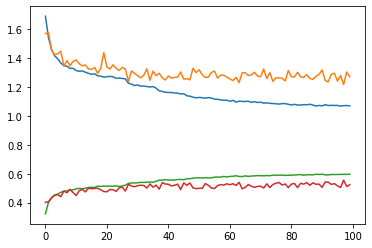

In [7]:
plt.plot(hist)

In [49]:
test_model = torch.load('temp_deepemotion.pt.pt')
test_model

Deep_Emotion(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (norm): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=810, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=7, bias=True)
  (localization): Sequential(
    (0): Conv2d(1, 8, kernel_size=(7, 7), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(8, 10, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplac

In [59]:
hooks = {}

def get_activation(name):
    def hook_fn(model, input, output):
        hooks[name] = output.detach()
        
    return hook_fn

for name, module in test_model.named_modules():
    print(name)
    module.register_forward_hook(get_activation(name))


conv1
conv2
pool2
conv3
conv4
pool4
norm
fc1
fc2
localization
localization.0
localization.1
localization.2
localization.3
localization.4
localization.5
fc_loc
fc_loc.0
fc_loc.1
fc_loc.2


In [79]:
images, labels = next(iter(train_loader))

In [80]:
t = test_model(images.to(device))

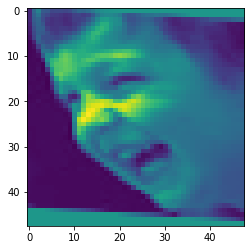

In [82]:
theta = hooks['fc_loc']
theta = theta.view(-1, 2, 3)
grid = F.affine_grid(theta, images.size())
        
sample = F.grid_sample(images.to(device), grid)

plt.imshow(sample.detach().cpu().numpy()[0,0,:,:])

In [40]:
class Deep_Emotion(nn.Module):
    def __init__(self):
        '''
        Deep_Emotion class contains the network architecture.
        '''
        super(Deep_Emotion,self).__init__()
        self.conv1 = nn.Conv2d(1,10,3)
        self.conv2 = nn.Conv2d(10,10,3)
        self.pool2 = nn.MaxPool2d(2,2)

        self.conv3 = nn.Conv2d(10,10,3)
        self.conv4 = nn.Conv2d(10,10,3)
        self.pool4 = nn.MaxPool2d(2,2)

        self.norm = nn.BatchNorm2d(10)

        self.fc1 = nn.Linear(810,50)
        self.fc2 = nn.Linear(50,7)

        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        self.fc_loc = nn.Sequential(
            nn.Linear(640, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 640) # flatten
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        return theta

    def forward(self,input):
        theta = self.stn(input)

        out = F.relu(self.conv1(input))
        out = self.conv2(out)
        out = F.relu(self.pool2(out))

        out = F.relu(self.conv3(out))
        out = self.norm(self.conv4(out))
        out = F.relu(self.pool4(out))

        out = F.dropout(out)
        
        grid = F.affine_grid(theta, (out.size()))
        mask = F.grid_sample(out, grid)
        out = out * mask
        
        out = out.view(-1, 810)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)

        return out

In [41]:
from torch.optim import lr_scheduler

device = torch.device('cuda')
print(device)

model = Deep_Emotion()

criterion = nn.CrossEntropyLoss()

learning_rate = 0.005
# reduce_factor = 2
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8, verbose=True)

cuda


In [42]:
model = model.to(device)

model_folder = './'
model_name = 'temp_deepemotion2'
model_path = os.path.join(model_folder, model_name + '.pt')

best_acc = 0.0
curloss = 0.0
hist = []

for epoch in range(100):

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0

    # TRAIN
    model.train()
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_acc += acc
#         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

    print('- Avg.loss: %.3f  | Avg.acc: %.3f' % (running_loss / (i+1), running_acc / (i+1)))
    avgloss = running_loss / (i+1)
    avgacc = running_acc / (i+1)
    
    # print gradient flow figure
#     plot_grad_flow(model.named_parameters(), epoch, avgloss, avgacc,
#                    savepath=os.path.join(model_folder, model_name + '_gf' + '_' + str(epoch) + '.png'))

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
        
#         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

        running_valloss += loss.item()
        running_valacc += acc

    print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / (i+1), running_valacc / (i+1)))

    avgvalloss = running_valloss / (i+1)
    avgvalcc = running_valacc / (i+1)

    hist.append([avgloss, avgvalloss, avgacc, avgvalcc])
    
    if best_acc < (running_valacc / (i+1)):
        best_acc = (running_valacc / (i+1))
        curloss = (running_valloss / (i+1))
        torch.save(model, model_path)
        print('* Update optimal model')
        
    scheduler.step(avgvalloss)

print('Finished Training')

Epoch:  1
- Avg.loss: 1.747  | Avg.acc: 0.287
- Avg. val_loss: 1.639  | Avg. val_acc: 0.363
* Update optimal model
Epoch:  2
- Avg.loss: 1.612  | Avg.acc: 0.367
- Avg. val_loss: 1.590  | Avg. val_acc: 0.397
* Update optimal model
Epoch:  3
- Avg.loss: 1.554  | Avg.acc: 0.394
- Avg. val_loss: 1.518  | Avg. val_acc: 0.403
* Update optimal model
Epoch:  4
- Avg.loss: 1.520  | Avg.acc: 0.408
- Avg. val_loss: 1.506  | Avg. val_acc: 0.400
Epoch:  5
- Avg.loss: 1.494  | Avg.acc: 0.419
- Avg. val_loss: 1.466  | Avg. val_acc: 0.418
* Update optimal model
Epoch:  6
- Avg.loss: 1.467  | Avg.acc: 0.430
- Avg. val_loss: 1.473  | Avg. val_acc: 0.423
* Update optimal model
Epoch:  7
- Avg.loss: 1.461  | Avg.acc: 0.428
- Avg. val_loss: 1.493  | Avg. val_acc: 0.404
Epoch:  8
- Avg.loss: 1.440  | Avg.acc: 0.443
- Avg. val_loss: 1.426  | Avg. val_acc: 0.446
* Update optimal model
Epoch:  9
- Avg.loss: 1.423  | Avg.acc: 0.449
- Avg. val_loss: 1.456  | Avg. val_acc: 0.423
Epoch:  10
- Avg.loss: 1.408  | Av

- Avg.loss: 0.927  | Avg.acc: 0.652
- Avg. val_loss: 1.442  | Avg. val_acc: 0.513
Epoch:  83
- Avg.loss: 0.924  | Avg.acc: 0.652
- Avg. val_loss: 1.455  | Avg. val_acc: 0.497
Epoch:  84
- Avg.loss: 0.927  | Avg.acc: 0.651
- Avg. val_loss: 1.428  | Avg. val_acc: 0.514
Epoch:  85
- Avg.loss: 0.926  | Avg.acc: 0.651
- Avg. val_loss: 1.464  | Avg. val_acc: 0.484
Epoch:  86
- Avg.loss: 0.926  | Avg.acc: 0.654
- Avg. val_loss: 1.450  | Avg. val_acc: 0.499
Epoch:  87
- Avg.loss: 0.922  | Avg.acc: 0.654
- Avg. val_loss: 1.463  | Avg. val_acc: 0.490
Epoch:  88
- Avg.loss: 0.928  | Avg.acc: 0.652
- Avg. val_loss: 1.441  | Avg. val_acc: 0.498
Epoch    88: reducing learning rate of group 0 to 1.9531e-05.
Epoch:  89
- Avg.loss: 0.924  | Avg.acc: 0.652
- Avg. val_loss: 1.443  | Avg. val_acc: 0.510
Epoch:  90
- Avg.loss: 0.921  | Avg.acc: 0.652
- Avg. val_loss: 1.423  | Avg. val_acc: 0.511
Epoch:  91
- Avg.loss: 0.926  | Avg.acc: 0.652
- Avg. val_loss: 1.460  | Avg. val_acc: 0.503
Epoch:  92
- Avg.lo

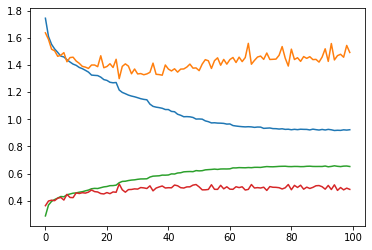

In [43]:
plt.plot(hist)

In [22]:
model = Deep_Emotion()
model(torch.rand(128, 1, 48, 48)).size()

torch.Size([128, 6])
torch.Size([128, 2, 3])
torch.Size([128, 1, 48, 48])
torch.Size([128, 48, 48, 2])
torch.Size([128, 1, 48, 48])


torch.Size([128, 7])

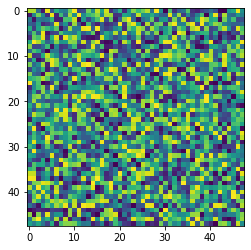

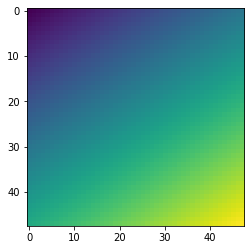

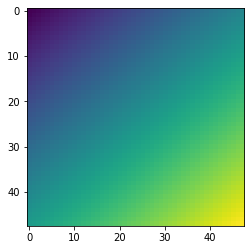

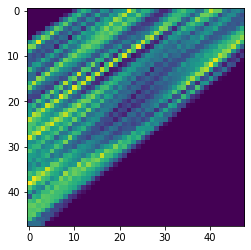

In [59]:
x = torch.rand(128, 1, 48, 48)
plt.imshow(x[0,0,:,:])
plt.show()
theta = torch.rand(128, 2, 3)
grid = F.affine_grid(theta, x.size())
plt.imshow(grid[0,:,:,0])
plt.show()
plt.imshow(grid[0,:,:,1])
plt.show()
sample = F.grid_sample(x, grid)
plt.imshow(sample[0,0,:,:])

In [43]:
grid.size()

torch.Size([128, 48, 48, 2])